# Handling Periodic Noise in Forcast Data

- Aim: Deal with periodic noise in Forcast
- Data: Level 3 grism data
- Tools: astropy, FFT 
- Instrument: FORCAST
- Documentation: FORCAST Noise Handling

## Content
- Introduction
- Technique 1
- Quantifying the noise correction
- Examples
- Techinque 2
- Conclusion

##### Date Published :  April 10, 2023

## Introduction

There are a variety of periodic noises observed in the data from the FORCAST instrument. 
The periodic noise in these images seems to occur in the 19.7um filter mostly. This is due to poor nod subtraction, where the noise is caused by the emission from the telescope. 

It can have various patterns, for example: hatched pattern, off-diagonal, or along the diagonal. Attached below are a few examples demonstrating this effect. 


The image below shows zoomed in images of individual unsubtracted nods that are not aligned so you can see the bright nod noise. If you look at the smaller top image in the ds9 you see the full frame. The noise is not exactly uniform with some curves and darker areas. It also can sometimes appear as a cross hatched pattern.

IMAGE WITH CROSS HATCHED PATTERN
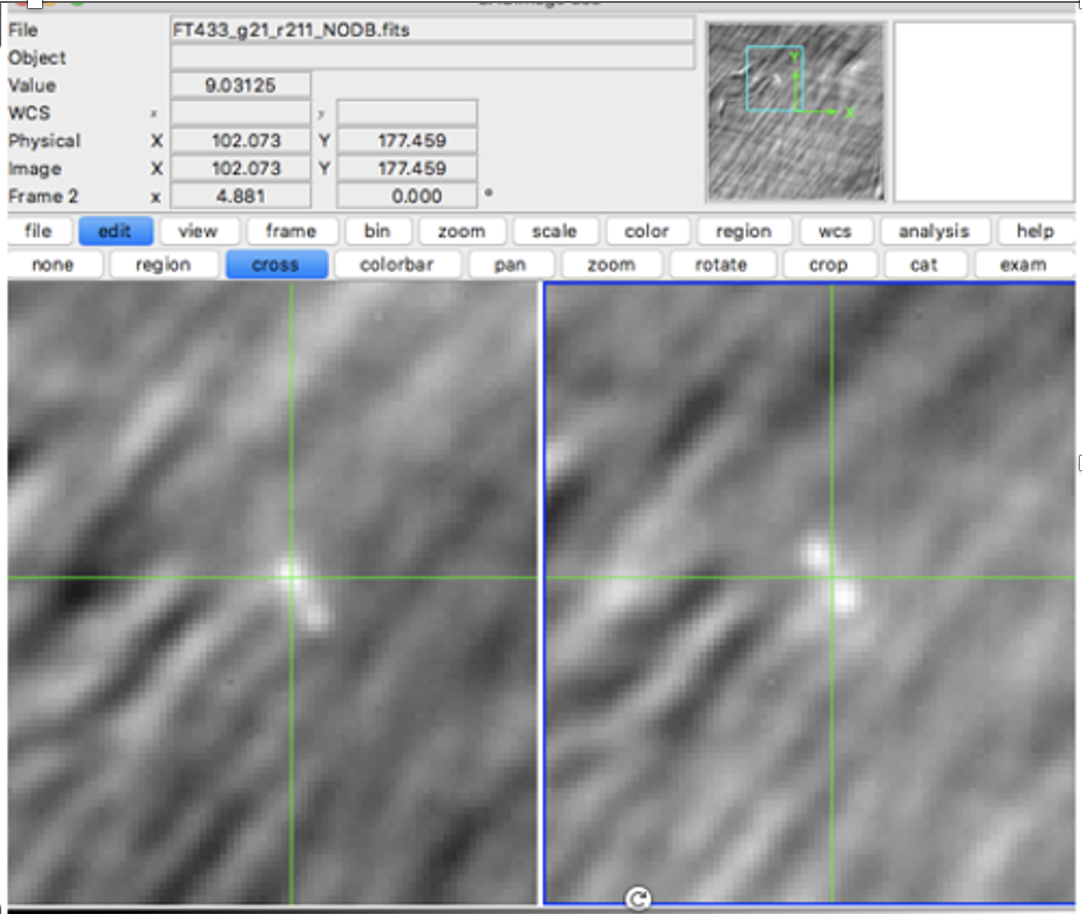

OFF-DIAGNOAL PERIODIC NOISE
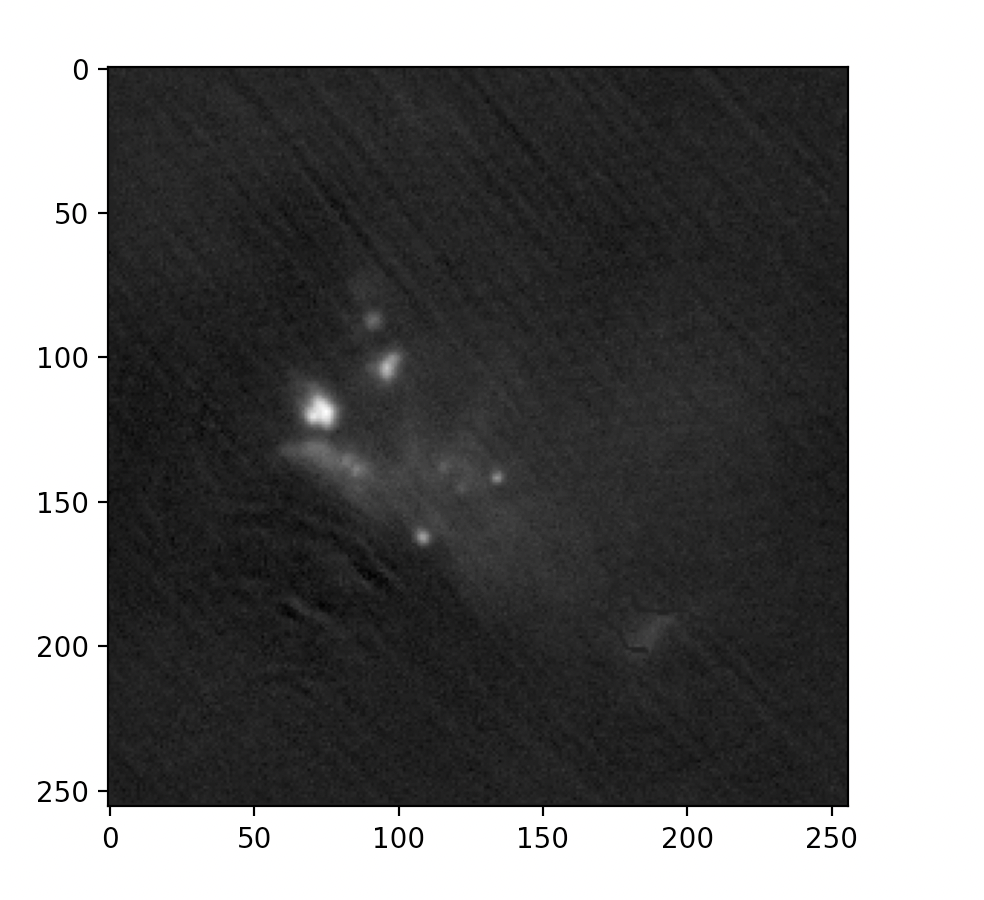

## Technique 1
As demonstrated above, periodic strips can be seen across various FORCAST dataset. This effect can be corrected by filtering out the frequencies contributing to the periodic noise in the Fourier domain. 
This technique is called <b>notch filtering.

 <b> Please note that this method does not improve the data quality but only improves the image quality. 

### Processing Steps

- Import the required libraries
- Readin the data files
- Replace the NaNs with median value
- Obtain the FFT
- FFT shift for moving the DC frequencies to the center.
- Identify the bad frequencies and apply the filtering
- First inverse FFTshift and then inverse FFT
- Assess the image quality and signal loss

#### Imports

In [1]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import astropy.io.fits as fits

#### Readin the Data Files and replace Nans

In [2]:
%%capture

# Read in data
filename = 'example_data/FORCAST/F0435_FO_IMA_05000851_FORF197_MRG_0074.fits'
im = fits.open(filename)[0].data
sz = np.shape(im)

# Based on type of data parse the image data. 

# For 3-dimensional dataset 
if im.ndim > 2:
    img = im[0, :, :]
# For 2-dimensional dataset 
else:
    img = im
    
#Replace the Nan in the image with median values
med = np.nanmedian(img)
img = np.nan_to_num(img, nan = med)

#plot the original image
fig,ax = plt.subplots(2,2, figsize=(10,10))

In [3]:
ax[0,0].imshow(img, cmap='viridis')
ax[0,0].set_title('Original Image')
fig.tight_layout()

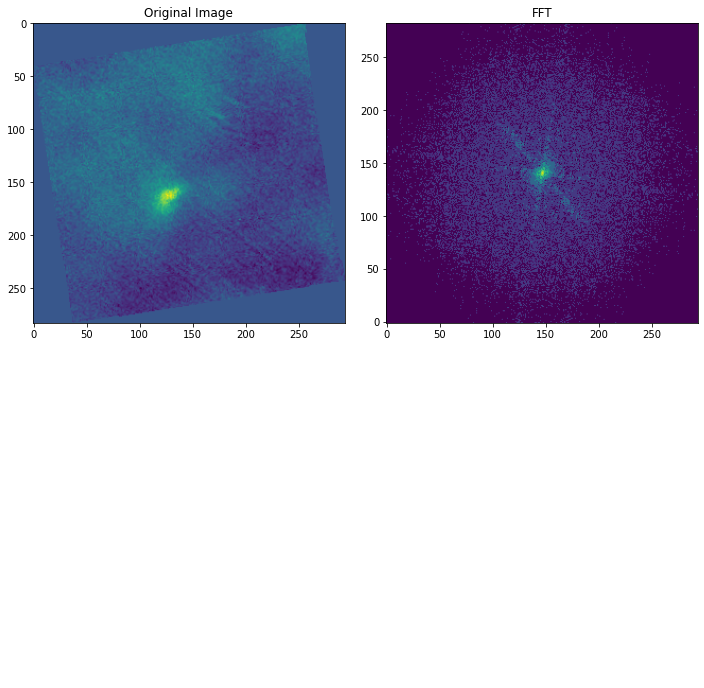

In [4]:
# FFT of the image
data_fft = scipy.fft.fft2(img)
fft_s = scipy.fft.fftshift(data_fft)

# real and imaginary parts
fft_r = fft_s.real 
fft_i = fft_s.imag

# Plot the absolute value in the frequency domain as these are complex numbers
ax[0,1].imshow(np.log(1+abs(fft_s)).astype(np.uint8), origin='lower')
ax[0,1].set_title('FFT')
ax[1,0].axis('off')
ax[1,1].axis('off')
fig

In the FFT, frequencies along the diagonal ($y=-cx$, , where $c > 0$) are contributing to the periodic noise in the forcast data. For this purpose, we first identify the center spot in the FFT by finding the maxima in the data as those represent the DC frequencies and should not be modified or else it may affect the flux of the source. 

We apply fitering boxes such that they enclose the bad frequencies along $y = -c x$. Most importantly, these boxes are offset from the center spot to maintain the image quality and avoid flux loss to the image. 


In [5]:
iro2 = fft_r
iio2 = fft_i

# Identify the center region
fft_x, fft_y = np.unravel_index(fft_r.argmax(), fft_r.shape)

# FFT Filter
# The numbers have been used such that filtering boxes are away from center halo to 
#avoid any major loss to flux of the source. These numbers used here may vary with dataset. 


iro2[fft_x-30:fft_x-10,fft_y+10:fft_y+30] = 0
iio2[fft_x-30:fft_x-10,fft_y+10:fft_y+30] = 0

# These box limits can be improved such that boxes are narrower and along y = -cx, where c>0.
# Here we have used rough boundaries around the bad frequencies for the sake of demonstration. 

iro2[fft_x+10:fft_x+40,fft_y-40: fft_y-10] = 0
iio2[fft_x+10:fft_x+40,fft_y-40: fft_y-10] = 0

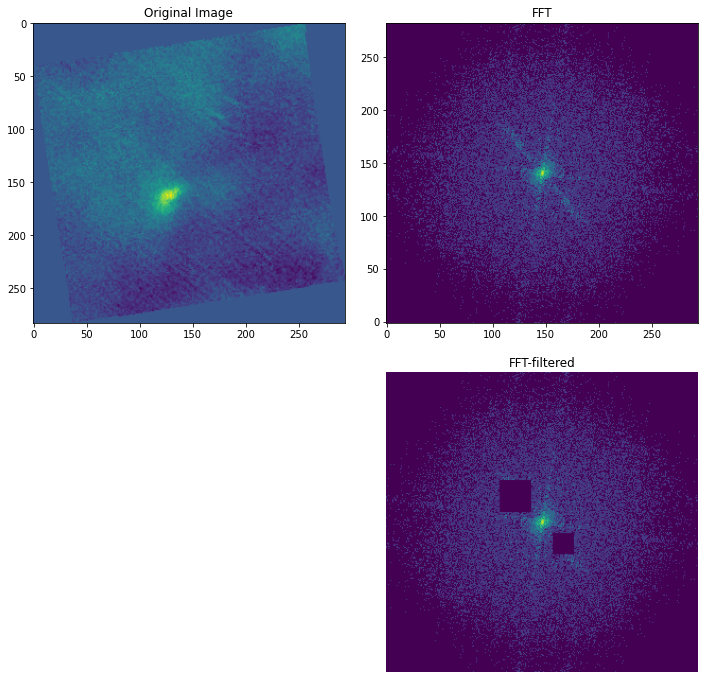

In [6]:
in2 = np.empty(img.shape, dtype=np.complex128)
in2.real = iro2
in2.imag = iio2
ax[1,1].imshow(np.log(1+abs(in2)).astype(np.uint8), origin='lower')
ax[1,1].set_title('FFT-filtered')
ax[1,1].tick_params(which='both', labelbottom=True, labelleft=True)
ax[1,0].axis('off')
fig

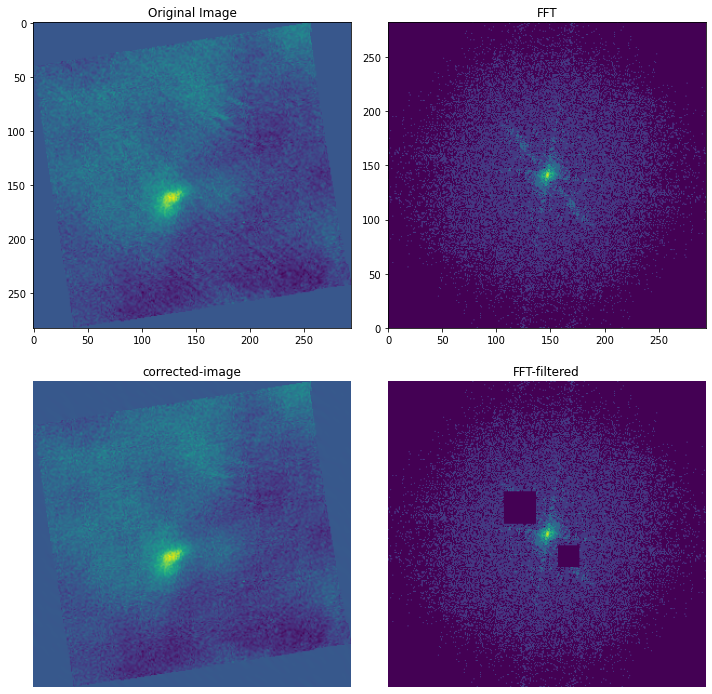

In [7]:
ic2 = scipy.fft.ifftshift(in2)
fixed_image = (scipy.fft.ifft2(ic2).real)
ax[1,0].imshow(fixed_image,cmap='viridis')
ax[1,0].set_title('corrected-image')
fig.tight_layout()
fig

## Quantifying the noise correction:

#### Peak Signal-to-Noise ratio (PSNR)
---------------------------------------
In order to quantify the notch filtering, we use *PSNR*. This method compares the noise *corrupted* image with noise *corrected* image. 


\begin{gather*}
PSNR = 20log_{10}\frac{L-1}{RMSE}
\end{gather*}

The higher the PSNR, the better the noise *corrupted* image has been reconstructed. This algorithm tries the minimize the mean-square-error between two images in comparison to the maximum signal of the image. For identical images, MSE is 0 and will lead to a PSNR value of infinity.

Here, *L* is the maximum possible intensity level in an image. *RMSE* is the root mean square error which can be given by
    
\begin{gather*}
RMSE = \sqrt{MSE}\\
MSE = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}\left ( O(i, j) - D(i, j)\right )^{2}\
\end{gather*}

*O* is the matrix data for the uncorrupted image, and *D* is the matrix data of degraded image.      

In [8]:
# define the PSNR function
 
def PSNR(original, compressed):
    """
    original - noise corrected image
    compressed - noise corrupteed image
    """
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  
        # MSE is zero means no noise is present in the signal. Therefore PSNR have no importance.
        return 100
    max_pixel = np.nanmax(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [9]:
PSNR(fixed_image.real,img)

37.91203871109059

Here $PSNR$ is $>0$ implying that we have been able to recreate most of the image.

Note : For other datasets, this code might need modification depending on their type. 

## Examples
Below we add several examples of how this effect needs to be treated depending on each case. 

<b>Example 1: Images with point sources. 
    
SINGLE POINT SOURCE WITH DOUBLE NEGATIVES
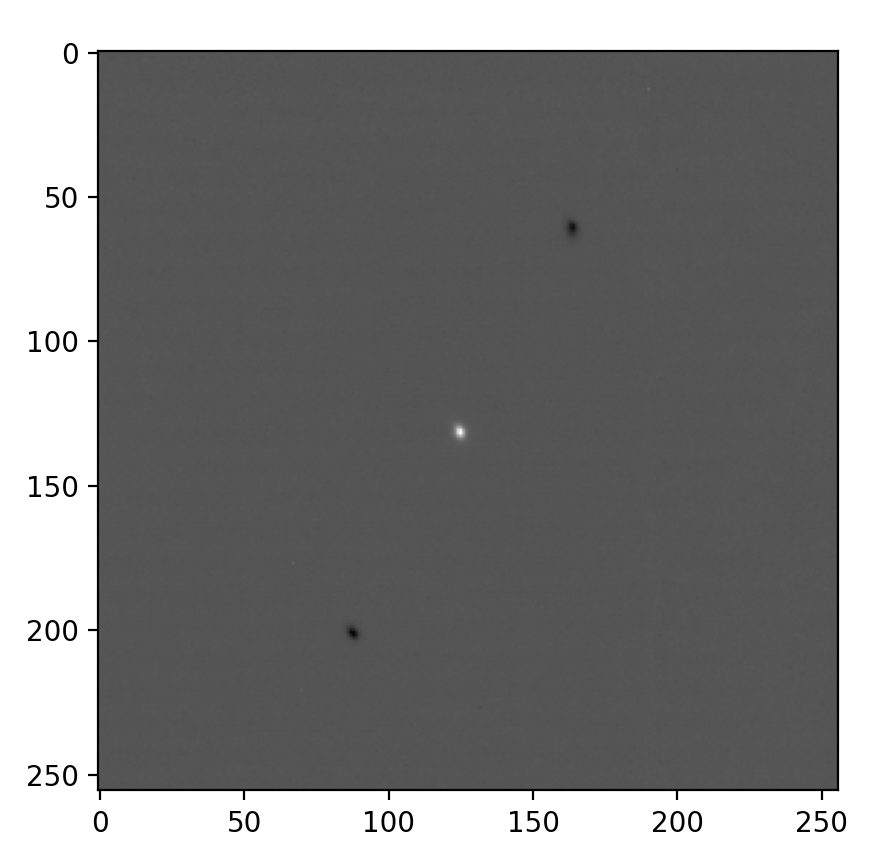

This image does not show the periodic noise. This example has been used for demonstration purpose only. For some sources taken in nod-match-chop mode, double negative sources get introduced as artifacts during the data processing. These negative sources contribute to fringes (periodic pattern) in the frequency domain (FFT), making it difficult to discern the desired frequencies from undesired. Hence, we will NOT be able to correct for this type of images using notch filtering. 


If we assume that the periodic noise always originates from the same frequencies and apply the notch filter, the inverse FFT obtains the following image. 

NOTCH FILTER STEPS FOR SINGLE POINT SOURCE
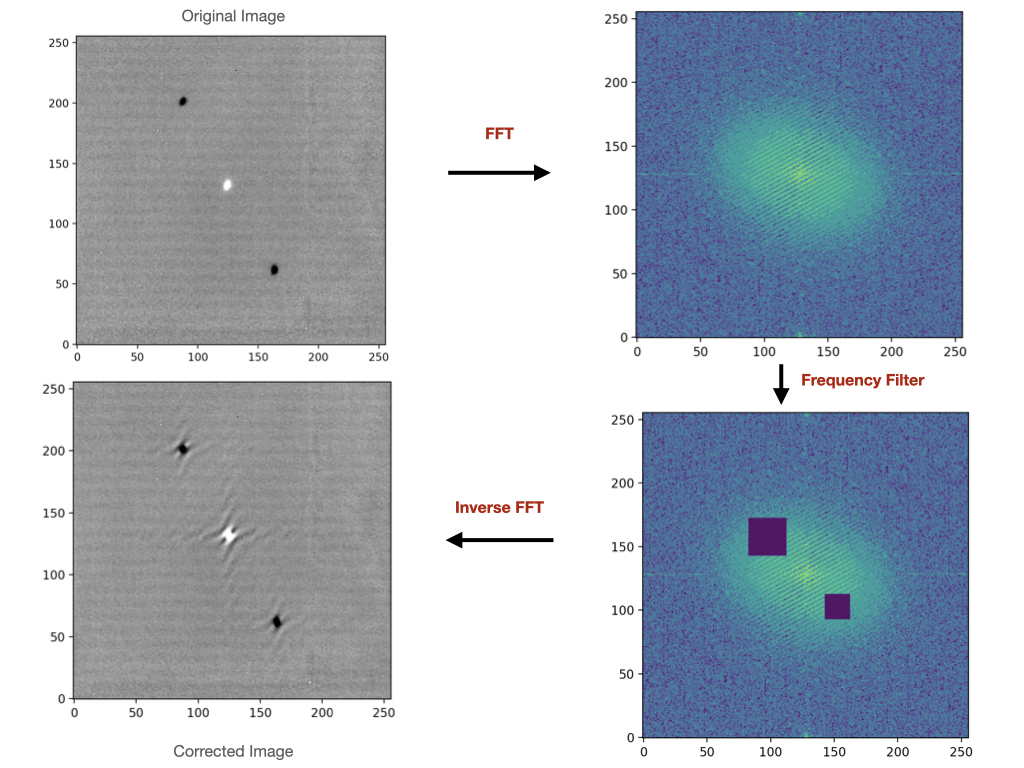

The above panel shows multiple images to demonstrate step by step notch filter application for a single source with double negative source. As you can see that the Inverse FFT of a filtered FFT map here introduces unwanted distortions around the point source and hence, can NOT be used. 

<b>Example 2: When the image is not tilted.

The original example that we have used here in the demonstration, has a tilted image, following a rotation to the standard coordinate system orientation. If a rotation has not been applied, the FFT will also be oriented in a different direction and will need to be handled accordingly. 

NOTCH FILTER FOR UNTILTED IMAGE
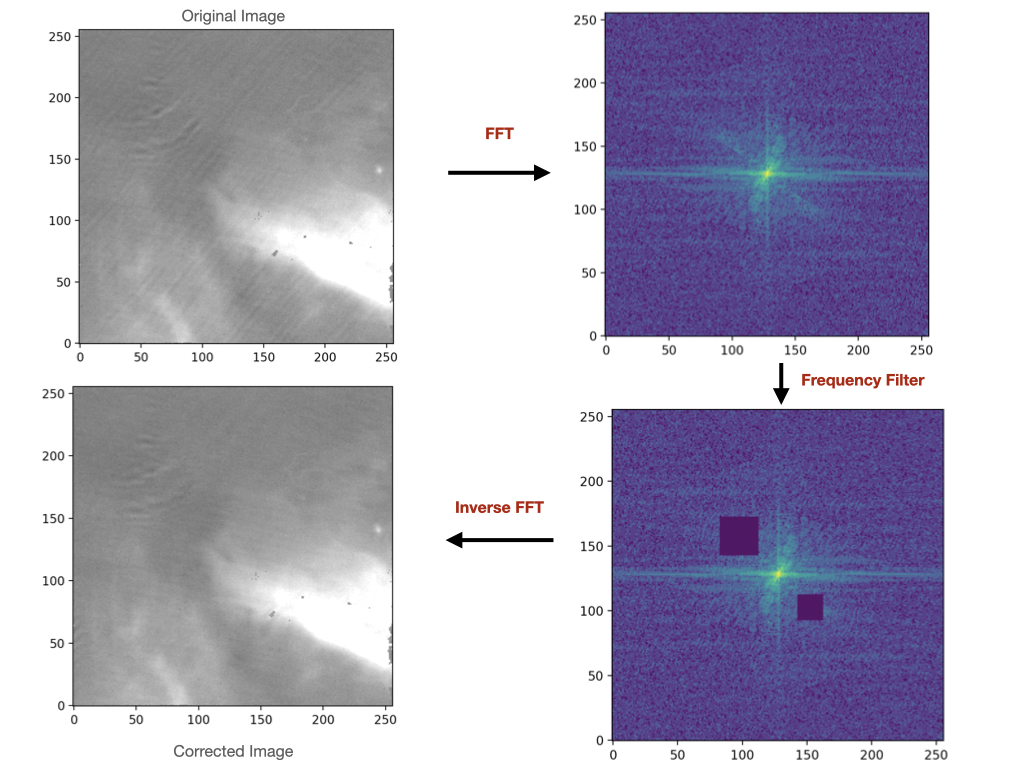

In the above case, we show four images starting from the original image which has the periodic noise along the diagonal. We have applied a FFT filter, which can be customized based on the data being handled, by changing the filtering range. The corrected image does not have the periodic lines along the diagonal but it has residual circular noise from the original image.

<b>Example 3: Multi point Source

NOTCH FILTER FOR MULTI-POINT SOURCE
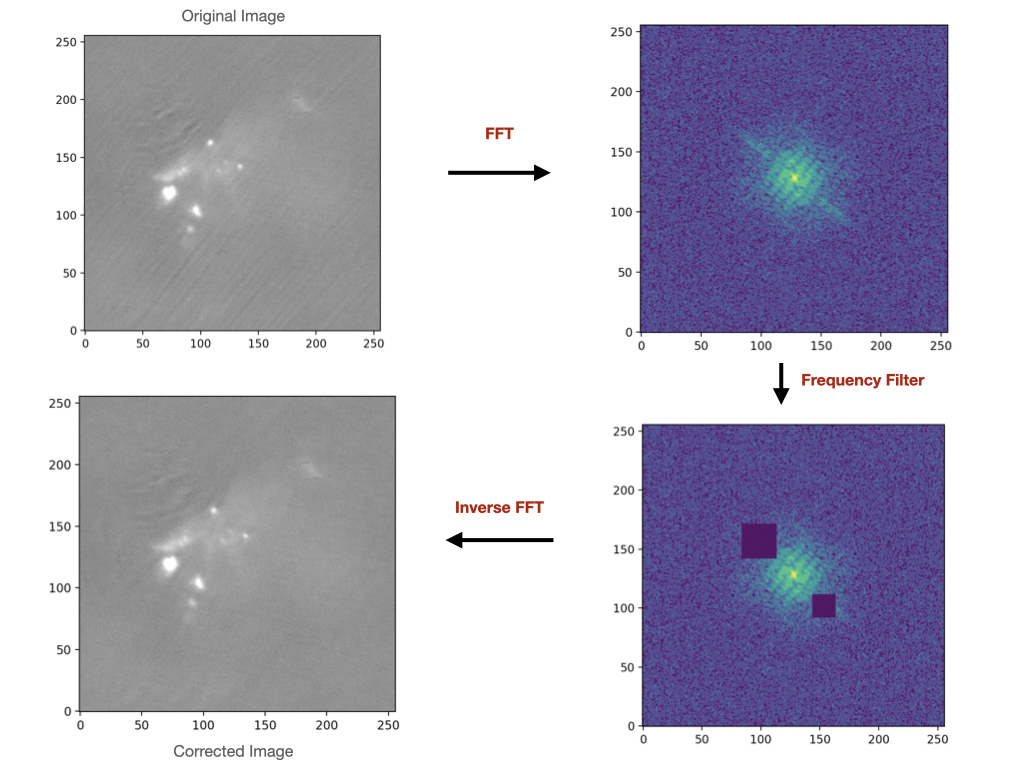

In case of a multi-point source, you may see additional fringes in the FFT (top right panel). This complicates the frequency filtering. Hence, one needs to be careful to apply the filter away from the fringes to avoid any disruptions to the original source. 

## Technique 2 

<b> Adaptive Gaussian notch filter for removing periodic noise from digital images (Varghese et al., IET Image processing, 2020, doi: 10.1049/iet-ipr.2018.5707)

Instead of finding the center and boundaries around the bad frequencies in the FFT domain manually, this method identifies these areas automatically. This algortithm searches for bad regions by comparing the area of an inner box with the outside box, defined by $W1$ and $W2$ for a given threshold. 

There are five key parameters which need to be adjusted depending on the data set. 
    
$0<Th<1$ - threshold (float) for comparing the area in the inner box with the outside box. A larger value of *Th* will allow more points to be filtered out. However, this also depends on other parameters as well. 
    
$1<=W1$ - an integer, initial size of the inner box. This number needs to be played with depending on the dataset. A smaller number (for eg. $W1 =1$) leads to more filtering whereas a higher number can be more selective. 
    
$W2$ - an integer, size of the outer box and is always $> W1$. It can be defined as $W1+c$, where *c* usually ranges between $1-3$. Please note that the value of *c* can be bigger and needs to be explored depending on your dataset.
    
$W1< Wmax$ - an integer, maximum size of the outer box and usually $<15$.

$L_{rgn}$ - an integer, maximum distance from the center region. For Forcast data use $>11$.
    


In [10]:
# Imports

import numpy as np
import astropy.io.fits as fits
import scipy
from PIL import Image
import matplotlib.pyplot as plt


class AdapFilter:
    """
    Adaptive Filter for identifying and flagging bad frequency regions.
    """
    def __init__(self, filename):

        self.power = None
        self.Fin = None
        self.Fin_shift = None
        self.Fout = None
        self.fixed_image = None
        self.Fout_shift = None
        self.img = None
        self.filename = filename

    def readin(self):
        """ Read in files either FITS or PNG """

        if 'fits' in self.filename:
            im = fits.open(self.filename)[0].data
            sz = np.shape(im)
            if len(sz) > 2:
                img = im[0, 0:sz[1] - 1, 0:sz[2] - 1]
            else:
                img = im
        else:
            im = np.array(Image.open(self.filename))

            sz = np.shape(im)
            print(sz)
            img = im[0:sz[0], 0:sz[1],0]

        med = np.nanmedian(img)
        self.img = np.nan_to_num(img, nan=med)


    def notch_filter(self, i, j, W2):
        """
        This modifies the output FFT point by applying the filter value
        """
        F1 = self.Fin_shift
        F2 = self.Fout
        for k in range(-W2, W2):
            for l in range(-W2, W2):
                # Notch filter multiplier. Here we have used the exponent as 0.0005 and this value can be played with. 
                # The best way to understand this is to assign h = 0 and see how the filtering works. 
                h = 1 - np.exp(-0.0005 * (k ** 2 + l ** 2))
                F2[i + k, j + l] = min(F2[i + k, j + l], F1[i + k, j + l] * h)
        self.Fout = F2


    def areap(self,w1, w2, m, n):
        
        """
        Obtain the normalized area of the inner and outer boxes
        """
        temp = 0
        temp1 = 0
        count = 0
        count1 = 0

        for p in range(-w2, w2):
            for q in range(-w2, w2):
                if (abs(p) <= w1) and (abs(q) <= w1):
                    temp = temp + self.power[m + p, n + q]
                    count = count + 1
                else:
                    temp1 = temp1 + self.power[m + p, n + q]
                    count1 = count1 + 1
        return temp / count, temp1 / count1


    def agnf(self):
        # read in the data
        self.readin()
        M, N = np.shape(self.img)
        print(M,N)
        self.Fin = scipy.fft.fft2(self.img) # Initial FFT
        self.Fin_shift = scipy.fft.fftshift(self.Fin)
        self.Fout = self.Fin_shift.copy() # Uncorrected F_out

        # Absolute value of the FFT
        self.power = (self.Fin_shift.real ** 2 + self.Fin_shift.imag ** 2) ** 0.5

        # Parameters
        Th = 0.62 # Threshold
        Wmax = 11 # Maximum outer box size
        L_rgn = 21 # Maximum distance from the center

        # identify the area
        for i in range(Wmax, M - Wmax):
            for j in range(Wmax, N - Wmax):
                d = ((i - (M / 2)) ** 2 + (j - (N / 2)) ** 2) ** 0.5
                fl = 0
                if d > L_rgn:
                    W1 = 7 # inner box initial size
                    cond = 1
                    while cond == 1:
                        W2 = W1 + 1 # Outer box
                        S1, S2 = self.areap(W1, W2, i, j)
                        if S1 > 0:
                            if (S2 / S1) <= Th:
                                fl = 1
                                if W2 > Wmax:
                                    cond = 0
                                else:
                                    W1 = W1 + 1
                                if fl == 1:
                                    self.notch_filter(i, j, W2)
                            else:
                              cond = 0
                        else:
                           cond = 0

        self.Fout_shift = scipy.fft.ifftshift(self.Fout) # output FFT
        self.fixed_image = scipy.fft.ifft2(self.Fout_shift).real # Fixed image

Here is the result when we apply technique 2 to a clown image.
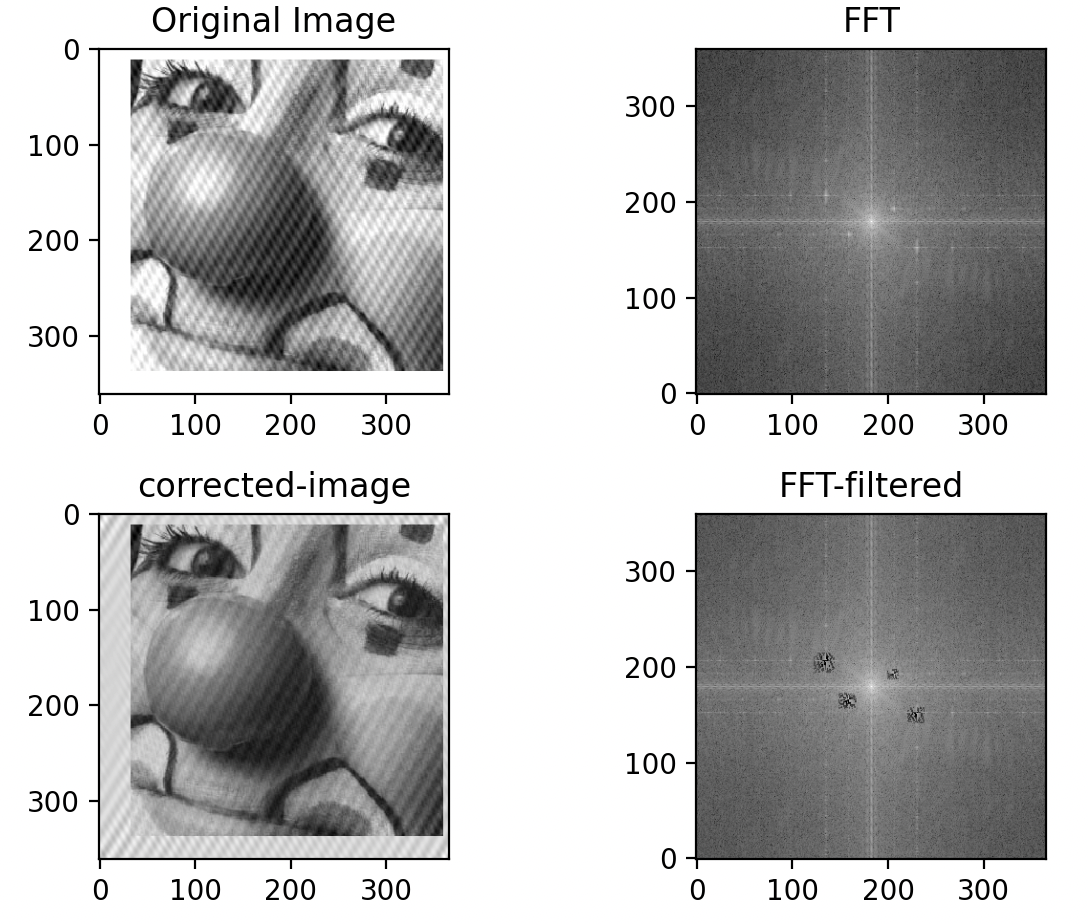

As you can see, the corrected image looks a lot more cleaner than the original image. This demonstrates that this method works. The additional lines in the empty space of the final image got introduced as there was no data originally, hence, should be omitted before processing.

For this example, we used the following parameters:
$Th = 0.32$, $Wmax =11$, $L_rgn = 21$, $W1 =1$, $W2 = W1+1$

Here is the result when we apply technique 2 to our original example used in technique 1.

282 293


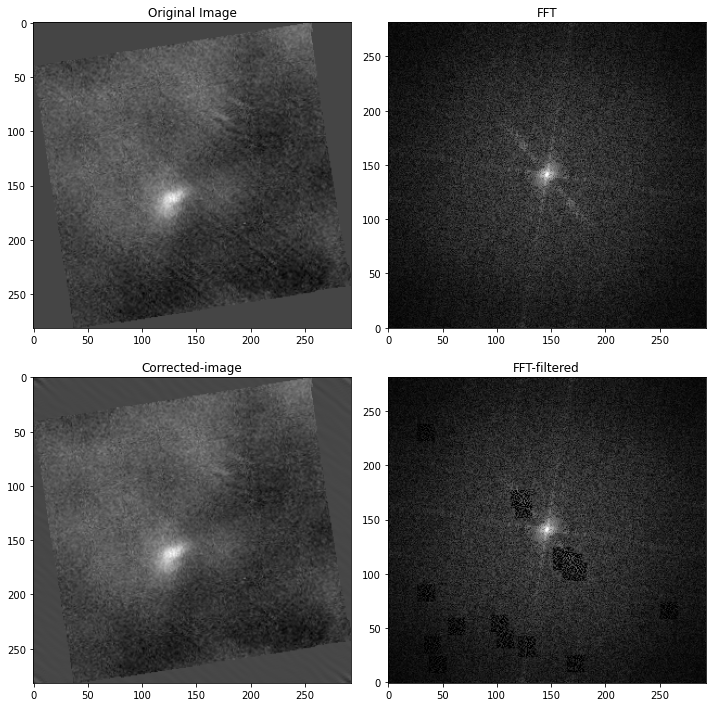

In [11]:
obj = AdapFilter('example_data/FORCAST/F0435_FO_IMA_05000851_FORF197_MRG_0074.fits')
obj.agnf()

fig,ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].imshow(obj.img ,cmap='gray')
ax[0,0].set_title('Original Image')
ax[0,1].imshow(np.log(1 + abs(obj.Fin_shift)), cmap='gray',origin='lower')
ax[0,1].set_title('FFT')
ax[1,1].imshow(np.log(1 + abs(obj.Fout)), cmap='gray', origin='lower')
ax[1,1].set_title('FFT-filtered')
ax[1,0].imshow(obj.fixed_image.real, cmap='gray')
ax[1,0].set_title('Corrected-image')

fig.tight_layout()

In [12]:
PSNR(obj.fixed_image.real,obj.img)

41.10532760620117

This technique works quite well as it is able to identify the bad frequency regions similar to the technique 1. However, we still see some residual periodic noise in the original image. The PSNR value for technique 2 is pretty close to technique 1. 

## Conclusion
The result of technique 1 looks slightly less noisy in comparison to technique 2. The reason is because technique 1 is a manual approach, where we identify these regions by eye and then apply the filtering. However, based on these demonstrations, a user may choose either of the two techniques. Please note that as technique 2 is an iterative method, it may take a bit longer than technique 1.